# Titanic  Survivership prediction

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we will build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# 1. Load data

In [159]:
# Import dependence
import numpy as np
import pandas as pd

In [160]:
# Load data     ####################################################################################################################
df1=pd.read_csv('train.csv')
df2=pd.read_csv('test.csv')
df=pd.concat([df1,df2])

In [161]:
# Check data shape
df1.shape

(891, 12)

In [162]:
# Check loaded data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [163]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# 2. Explore data (EDA)

In [164]:
# Import library
from ydata_profiling import ProfileReport


In [165]:
# Generate EDA report
profile_report = ProfileReport(df, title="titanic", minimal=True)

In [ ]:
# Display EDA report
profile_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 3. Build Machine Learning (ML) models

In [167]:
# Derive label / target variable  ###################################################################
df['Survived']=df['Survived'].dropna().astype('int')

In [168]:
# Further sanity checks
df['Survived'].value_counts()

0    804
1    505
Name: Survived, dtype: int64

In [169]:
# Further sanity checks
df['Survived'].unique()

array([0, 1])

## 3.1 Split data into training / validation sets

In [170]:
# Get label and features  ##########################################################################
X = df.drop(['Survived','PassengerId','Cabin','Name','Ticket'], axis='columns')
y = df[['Survived']]

In [171]:
# Check data
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [172]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [173]:
# Get list of categorical and numeric features  ###################################################
# We can use dataframe.info() to derive type of features
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Sex       1309 non-null   object 
 2   Age       1046 non-null   float64
 3   SibSp     1309 non-null   int64  
 4   Parch     1309 non-null   int64  
 5   Fare      1308 non-null   float64
 6   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 81.8+ KB


In [174]:
X['Pclass']=X['Pclass'].astype('object')

features_cat = X.select_dtypes(include='object').columns.tolist()
features_num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Features:", features_cat)
print("\nNumerical Features:", features_num)

Categorical Features: ['Pclass', 'Sex', 'Embarked']

Numerical Features: ['Age', 'SibSp', 'Parch', 'Fare']


In [175]:
# Split data into training and validation sets  #################################################
from sklearn.model_selection import train_test_split

RANDOM_STATE = 101
TEST_SIZE = 0.20

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, 
                                                  test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Sanity checks
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('\n')
print('X_val', X_val.shape)
print('y_val', y_val.shape)
print('\n')
print('Survivership (TRAIN):\n', y_train['Survived'].value_counts(dropna=False, normalize=True).round(2) * 100)
print('\n Survivership (VAL):\n', y_val['Survived'].value_counts(dropna=False, normalize=True).round(2) * 100)

X_train (1047, 7)
y_train (1047, 1)


X_val (262, 7)
y_val (262, 1)


Survivership (TRAIN):
 0    61.0
1    39.0
Name: Survived, dtype: float64

 Survivership (VAL):
 0    61.0
1    39.0
Name: Survived, dtype: float64


## 3.2 Impute missing values

In [176]:
# Get data by feature type
X_train_cat = X_train[features_cat]
X_val_cat = X_val[features_cat]

X_train_num = X_train[features_num]
X_val_num = X_val[features_num]

In [177]:
X_train_cat.head()

,Pclass,Sex,Embarked
198,2,male,S
266,1,male,S
678,3,female,S
535,2,female,S
47,3,male,Q


In [178]:
X_train_num.head()

,Age,SibSp,Parch,Fare
198,23.0,0,0,10.50
266,NaN,0,0,0.00
678,43.0,1,6,46.90
535,7.0,0,2,26.25
47,NaN,0,0,7.75


In [179]:
# Check missing data in categorical features
# IMPORTANT - No missing data!
X_train_cat.isnull().sum()

Pclass      0
Sex         0
Embarked    1
dtype: int64

In [180]:
# Check missing data in numeric features
# IMPORTANT - Two features have missing data!
X_train_num.isnull().sum()

Age      207
SibSp      0
Parch      0
Fare       1
dtype: int64

In [181]:
# Impute categorical features     ###############################################################################################################
# IMPORTANT - Although no missing data here, we show the framework for imputing missing data!

from sklearn.impute import SimpleImputer

# Apply imputer
imputer_cat = SimpleImputer(strategy='most_frequent')

X_train_cat_imputed = imputer_cat.fit_transform(X_train_cat)
X_train_cat_imputed = pd.DataFrame(X_train_cat_imputed, columns=X_train_cat.columns)

# Sanity checks
print('Number of missing values (BEFORE):\n', X_train_cat.isnull().sum())
print('\nNumber of missing values (AFTER):\n', X_train_cat_imputed.isnull().sum())

Number of missing values (BEFORE):
 Pclass      0
Sex         0
Embarked    1
dtype: int64

Number of missing values (AFTER):
 Pclass      0
Sex         0
Embarked    0
dtype: int64


In [182]:
# Impute validation set as well
X_val_cat_imputed = imputer_cat.transform(X_val_cat)
X_val_cat_imputed = pd.DataFrame(X_val_cat_imputed, columns=X_val_cat.columns)

# Sanity checks
print('Number of missing values (BEFORE):\n', X_val_cat.isnull().sum())
print('\nNumber of missing values (AFTER):\n', X_val_cat_imputed.isnull().sum())

Number of missing values (BEFORE):
 Pclass      0
Sex         0
Embarked    1
dtype: int64

Number of missing values (AFTER):
 Pclass      0
Sex         0
Embarked    0
dtype: int64


In [183]:
# Impute numeric features     ###############################################################################################################
imputer_num = SimpleImputer(strategy='median')

X_train_num_imputed = imputer_num.fit_transform(X_train_num)
X_train_num_imputed = pd.DataFrame(X_train_num_imputed, columns=X_train_num.columns)

# Sanity checks
print('Number of missing values (BEFORE):\n', X_train_num.isnull().sum())
print('\nNumber of missing values (AFTER):\n', X_train_num_imputed.isnull().sum())

Number of missing values (BEFORE):
 Age      207
SibSp      0
Parch      0
Fare       1
dtype: int64

Number of missing values (AFTER):
 Age      0
SibSp    0
Parch    0
Fare     0
dtype: int64


In [184]:
# Impute validation set as well
X_val_num_imputed = imputer_num.transform(X_val_num)
X_val_num_imputed = pd.DataFrame(X_val_num_imputed, columns=X_val_num.columns)

# Sanity checks
print('Number of missing values (BEFORE):\n', X_val_num.isnull().sum())
print('\nNumber of missing values (AFTER):\n', X_val_num_imputed.isnull().sum())

Number of missing values (BEFORE):
 Age      56
SibSp     0
Parch     0
Fare      0
dtype: int64

Number of missing values (AFTER):
 Age      0
SibSp    0
Parch    0
Fare     0
dtype: int64


In [185]:
# Save imputers for future use   ####################################################################################################

# Import library
import pickle
    
with open('imputer_cat', 'wb') as pkl:
    pickle.dump(imputer_cat, pkl)

with open('imputer_num', 'wb') as pkl:
    pickle.dump(imputer_num, pkl)

## 3.3 Feature scaling or normalization for numeric features

In [186]:
# Feature scaling for numeric variables   ############################################################################################

# Import library
from sklearn.preprocessing import StandardScaler

# Apply feature scaling
scaler = StandardScaler()

X_train_num_scaler = scaler.fit_transform(X_train_num_imputed)
X_train_num_scaler = pd.DataFrame(X_train_num_scaler, columns=X_train_num_imputed.columns)

# Sanity checks
X_train_num_scaler.head()

,Age,SibSp,Parch,Fare
0,-0.497337,-0.478676,-0.447079,-0.456085
1,-0.109229,-0.478676,-0.447079,-0.662177
2,1.055094,0.437547,6.288048,0.258369
3,-1.739281,-0.478676,1.797964,-0.146946
4,-0.109229,-0.478676,-0.447079,-0.510061


In [187]:
# Scale validation data as well
X_val_num_scaler = scaler.transform(X_val_num_imputed)
X_val_num_scaler = pd.DataFrame(X_val_num_scaler, columns=X_val_num_imputed.columns)

# Sanity checks
X_val_num_scaler.head()

,Age,SibSp,Parch,Fare
0,1.365580,-0.478676,-0.447079,-0.519875
1,-0.652580,1.353770,-0.447079,-0.188164
2,1.598444,-0.478676,-0.447079,-0.504173
3,-0.109229,-0.478676,-0.447079,-0.407015
4,-0.109229,2.269994,0.675443,-0.162321


In [188]:
# Save scaler for later use
with open('scaler', 'wb') as pkl:
    pickle.dump(scaler, pkl)

## 3.4 One-Hot Encoding for categorical features

In [189]:
# Check data before Encoding!
X_train_cat_imputed.head()

,Pclass,Sex,Embarked
0,2,male,S
1,1,male,S
2,3,female,S
3,2,female,S
4,3,male,Q


In [190]:
# Import library
from sklearn.preprocessing import OneHotEncoder

# Apply One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_cat_encoded = encoder.fit_transform(X_train_cat_imputed)
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded.toarray(), columns=encoder.get_feature_names_out(features_cat))

# Sanity checks after Encoding!
X_train_cat_encoded.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [191]:
# Encode validation data set as well
X_val_cat_encoded = encoder.transform(X_val_cat_imputed)
X_val_cat_encoded = pd.DataFrame(X_val_cat_encoded.toarray(), columns=encoder.get_feature_names_out(features_cat))

# Sanity checks after Encoding!
X_val_cat_encoded.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [192]:
# Save encoder for later use
with open('encoder', 'wb') as pkl:
    pickle.dump(encoder, pkl)

## 3.5 Combine processed data

In [193]:
# Combine data - TRAIN
X_train_ready = pd.concat([X_train_num_scaler, X_train_cat_encoded], axis='columns')

print('X_train_ready', X_train_ready.shape)
print('\n')

X_train_ready.head()

X_train_ready (1047, 12)




,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-0.497337,-0.478676,-0.447079,-0.456085,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.109229,-0.478676,-0.447079,-0.662177,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.055094,0.437547,6.288048,0.258369,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,-1.739281,-0.478676,1.797964,-0.146946,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.109229,-0.478676,-0.447079,-0.510061,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [194]:
# Combine data - VALIDATION
X_val_ready = pd.concat([X_val_num_scaler, X_val_cat_encoded], axis='columns')

print('X_val_ready', X_val_ready.shape)
print('\n')

X_val_ready.head()

X_val_ready (262, 12)




,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1.365580,-0.478676,-0.447079,-0.519875,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,-0.652580,1.353770,-0.447079,-0.188164,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.598444,-0.478676,-0.447079,-0.504173,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,-0.109229,-0.478676,-0.447079,-0.407015,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.109229,2.269994,0.675443,-0.162321,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


## 3.6 Build ML models

In [195]:
# Convert label from Pandas data frame to numpy for ML training
y_train = y_train.to_numpy().flatten()
y_val = y_val.to_numpy().flatten()

In [196]:
y_train.shape

(1047,)

In [197]:
type(y_train)

numpy.ndarray

In [198]:
y_train[:100]

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0])

In [199]:
# Sanity checks for distribution of child deaths
np.unique(y_train, return_counts=True)

(array([0, 1]), array([643, 404], dtype=int64))

In [200]:
np.unique(y_val, return_counts=True)

(array([0, 1]), array([161, 101], dtype=int64))

In [201]:
df['Survived'].unique()

array([0, 1])

In [202]:
# np.isnan(y_train).any()

pd.isnull(y_train).any()

False

### General Linear Model (Logistic regression model)

In [203]:
# Import library
from sklearn.linear_model import LogisticRegression

# Train ML model
RANDOM_STATE = 101

model_lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

model_lr.fit(X_train_ready, y_train)

LogisticRegression(max_iter=1000, random_state=101)

In [204]:
# Evaluate model
y_pred_lr = model_lr.predict(X_val_ready)

In [205]:
y_pred_lr[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0])

In [206]:
# Evaluate model performance using Confusion matrix and ROC #################################################################################################
from sklearn.metrics import confusion_matrix

# Get confusion matrix
confusion_matrix(y_true=y_val, y_pred=y_pred_lr)

array([[130,  31],
       [ 48,  53]], dtype=int64)

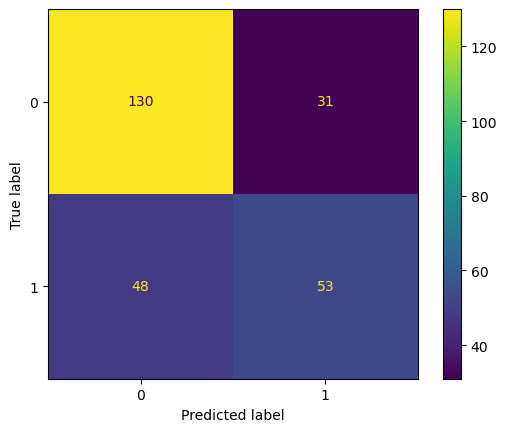

In [207]:
# Display confusion matrix
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import ConfusionMatrixDisplay

cm_lr = confusion_matrix(y_true=y_val, y_pred=y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=model_lr.classes_)
disp.plot()

plt.show()

In [208]:
# Calculate AUC
from sklearn.metrics import roc_auc_score

# Calculate prediction probability before calculating AUC
y_pred_prob_lr = model_lr.predict_proba(X_val_ready)
print('y_pred_prob_lr\n', y_pred_prob_lr[:10])

y_pred_prob_lr
 [[0.86513759 0.13486241]
 [0.82053434 0.17946566]
 [0.87303593 0.12696407]
 [0.66965245 0.33034755]
 [0.62732093 0.37267907]
 [0.75010443 0.24989557]
 [0.85915146 0.14084854]
 [0.75582328 0.24417672]
 [0.82284946 0.17715054]
 [0.80698847 0.19301153]]


In [209]:
auc_lr = roc_auc_score(y_val, y_pred_prob_lr[:, -1])
auc_lr

0.7223110509808744

In [210]:
# Plot ROC
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, th_lr = roc_curve(y_val, y_pred_prob_lr[:, -1])

In [211]:
# Custom function to plot ROC curve
def plot_roc_curve(fpr_list, tpr_list, label_list=None, auc_list=None):  
    assert isinstance(fpr_list, list), 'Please pass FPR in a list, e.g., [fpr_lr]'
    assert isinstance(tpr_list, list), 'Please pass TPR in a list, e.g., [fpr_lr]'
    
    if label_list is not None:
        assert isinstance(label_list, list), 'Please pass label in a list, e.g., [label_lr]'
        
    if auc_list is not None:
        assert isinstance(auc_list, list), 'Please pass AUC in a list, e.g., [auc_lr]'
    
    if label_list is None:
        label_list = [None] * len(fpr_list)
        
    if auc_list is None:
        auc_list = [None] * len(fpr_list)
        
    for fpr, tpr, label, auc in zip(fpr_list, tpr_list, label_list, auc_list):
        plt.plot(fpr, tpr, linewidth=2, 
                 label=''.join([label, ' (auc = ', str(round(auc * 100, 1)), '%)']) if label is not None else None,
                )
        plt.plot([0, 1], [0, 1], color='0.8')

        plt.xlabel("FPR (1 - Specificity)")
        plt.ylabel("TPR (Sensitivity)")
        
        if label is not None and auc is not None:
            plt.legend()

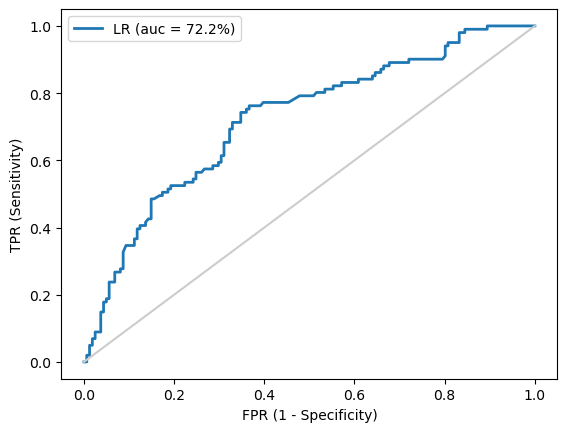

In [212]:
# Plot ROC for logistic regression model
plot_roc_curve([fpr_lr], [tpr_lr], label_list=['LR'], auc_list=[auc_lr])

## K-nearest Neighbors Model

In [213]:
# Load library
from sklearn.neighbors import KNeighborsClassifier

# Set Hyperparameters
N_NEIGHBORS = 10

# Train model
model_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)

model_knn.fit(X_train_ready, y_train)

KNeighborsClassifier(n_neighbors=10)

In [214]:
# Evaluate model
y_pred_knn = model_knn.predict(X_val_ready)

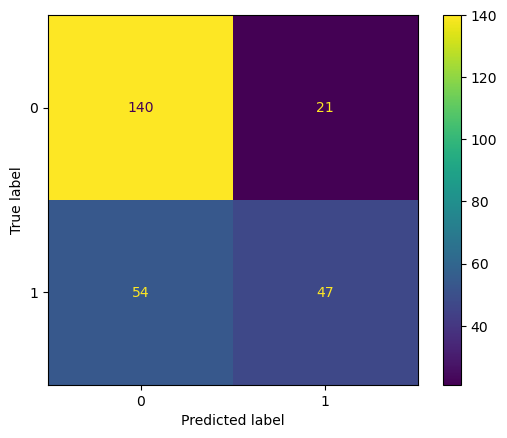

In [215]:
# Display confusion matrix
cm_knn = confusion_matrix(y_true=y_val, y_pred=y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=model_knn.classes_)
disp.plot()

plt.show()

In [216]:
# Calculate AUC
y_pred_prob_knn = model_knn.predict_proba(X_val_ready)

auc_knn = roc_auc_score(y_val, y_pred_prob_knn[:, -1])
auc_knn

0.7170838201832606

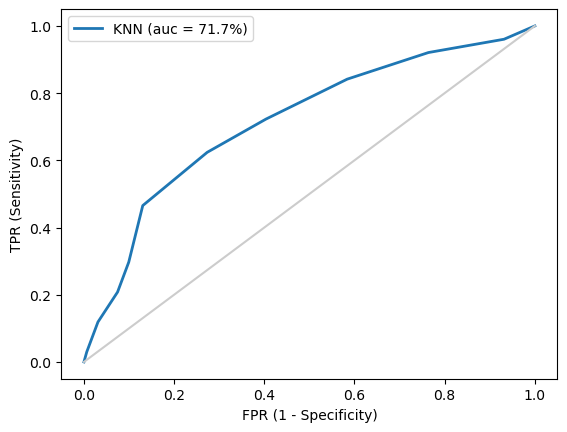

In [217]:
# ROC for KNN
fpr_knn, tpr_knn, th_knn = roc_curve(y_val, y_pred_prob_knn[:, -1])

plot_roc_curve([fpr_knn], [tpr_knn], label_list=['KNN'], auc_list=[auc_knn])

### Random Forest Model

In [218]:
# Load library
from sklearn.ensemble import RandomForestClassifier

# Set Hyperparameters
N_TREES = 250
N_DEPTH = 3

# Train model
model_rf = RandomForestClassifier(n_estimators=N_TREES, max_depth=N_DEPTH, random_state=RANDOM_STATE)

model_rf.fit(X_train_ready, y_train)

RandomForestClassifier(max_depth=3, n_estimators=250, random_state=101)

In [219]:
# Evaluate model
y_pred_rf = model_rf.predict(X_val_ready)

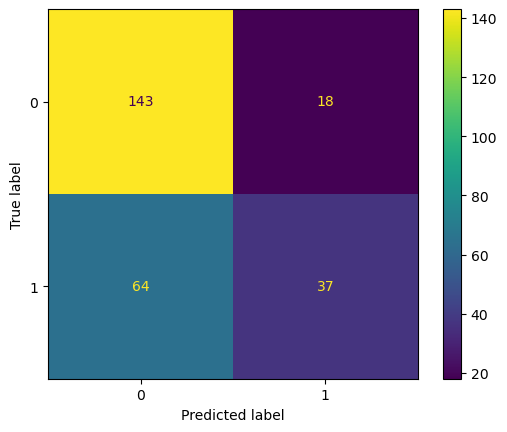

In [220]:
# Display confusion matrix
cm_rf = confusion_matrix(y_true=y_val, y_pred=y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=model_rf.classes_)
disp.plot()

plt.show()

In [221]:
# Calculate AUC
y_pred_prob_rf = model_rf.predict_proba(X_val_ready)

auc_rf = roc_auc_score(y_val, y_pred_prob_rf[:, -1])
auc_rf

0.7159153803579116

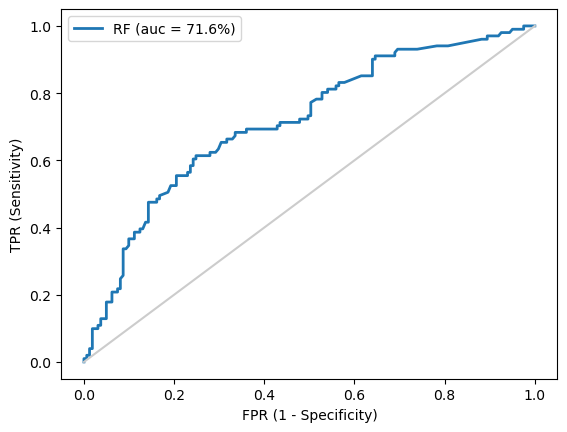

In [222]:
# ROC for RF
fpr_rf, tpr_rf, th_rf = roc_curve(y_val, y_pred_prob_rf[:, -1])

plot_roc_curve([fpr_rf], [tpr_rf], label_list=['RF'], auc_list=[auc_rf])

### Gradient Boosting - Catboost

In [223]:
# Import library
from catboost import CatBoostClassifier

# Set Hyperparameters
N_TREES = 250
LEARNING_RATE = 0.001
N_DEPTH = 5

# Train model
model_cb = CatBoostClassifier(iterations=N_TREES,
                              learning_rate=LEARNING_RATE,
                              depth=N_DEPTH, 
                              verbose=0)
# Fit model
model_cb.fit(X_train_ready, y_train)

In [224]:
# Evaluate model
y_pred_cb = model_cb.predict(X_val_ready)

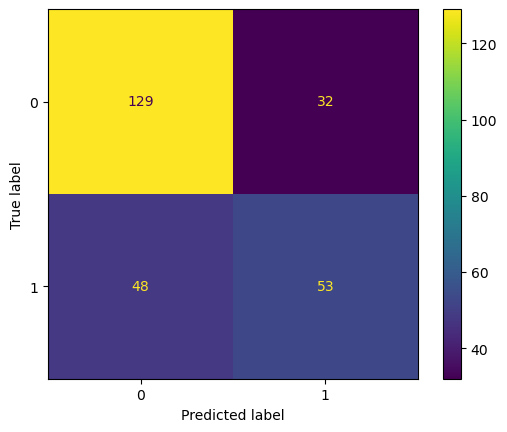

In [225]:
# Display confusion matrix
cm_cb = confusion_matrix(y_true=y_val, y_pred=y_pred_cb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cb, display_labels=model_cb.classes_)
disp.plot()

plt.show()

In [226]:
# Calculate AUC
y_pred_prob_cb = model_cb.predict_proba(X_val_ready)

auc_cb = roc_auc_score(y_val, y_pred_prob_cb[:, -1])
auc_cb

0.7188672283377406

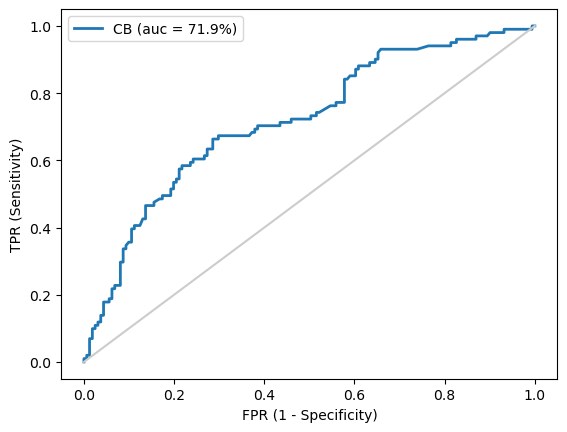

In [227]:
# ROC for RF
fpr_cb, tpr_cb, th_cb = roc_curve(y_val, y_pred_prob_cb[:, -1])

plot_roc_curve([fpr_cb], [tpr_cb], label_list=['CB'], auc_list=[auc_cb])

## Compare model performance for different ML algorithms

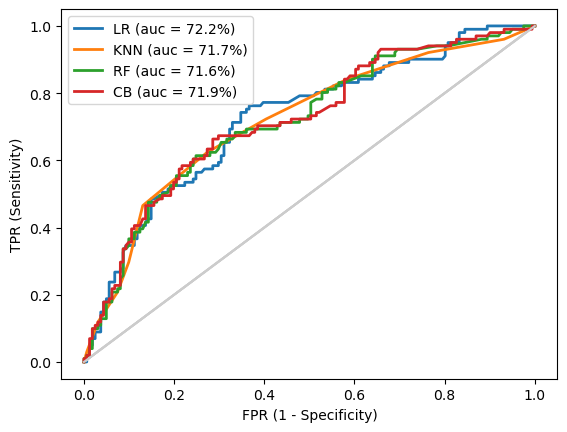

In [228]:
# Compare models using ROC curve
plot_roc_curve([fpr_lr, fpr_knn, fpr_rf, fpr_cb], 
               [tpr_lr, tpr_knn, tpr_rf, tpr_cb], 
               label_list=['LR', 'KNN', 'RF', 'CB'], 
               auc_list=[auc_lr, auc_knn, auc_rf, auc_cb])

# 4. Improve model performance

## 4.1 Address class imbalance

In [229]:
y_train_df = pd.DataFrame({
    'target': y_train
})

y_train_df

,target
0,1
1,0
2,0
3,1
4,1
...,...
1042,0
1043,1
1044,0
1045,1


In [230]:
# combine X_train and y_train into a single DataFrame
y_train_df = pd.DataFrame({
    'target': y_train
})

train_data = pd.concat([X_train_ready, y_train_df], axis=1)

# separate instances of each class
negative_class = train_data[train_data.target==0]
positive_class = train_data[train_data.target==1]

# randomly undersample the majority class
from sklearn.utils import resample

RANDOM_STATE = 101

negative_class_downsampled = resample(negative_class,
                                       replace=False,     # sample without replacement
                                       n_samples=len(positive_class),  # match minority class
                                       random_state=RANDOM_STATE)   # reproducible results

# combine minority class and downsampled majority class
downsampled = pd.concat([negative_class_downsampled, positive_class])
print('downsampled', downsampled.shape)

# separate input features and target variable
X_train_downsampled = downsampled.drop('target', axis=1)
y_train_downsampled = downsampled['target']

downsampled (808, 13)


In [231]:
y_train_downsampled.value_counts(normalize=True)

0    0.5
1    0.5
Name: target, dtype: float64

In [232]:
# Re-train LR after downsampling   ########################################################################################################################

# Train
RANDOM_STATE = 101
model_lr_downsampled = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model_lr_downsampled.fit(X_train_downsampled, y_train_downsampled)

# Evaluate model
y_pred_lr = model_lr_downsampled.predict(X_val_ready)

# Evaluate
y_pred_prob_lr = model_lr_downsampled.predict_proba(X_val_ready)
auc_lr_after = roc_auc_score(y_val, y_pred_prob_lr[:, -1])
auc_lr_after

0.7225570383125269

In [233]:
auc_lr

0.7223110509808744

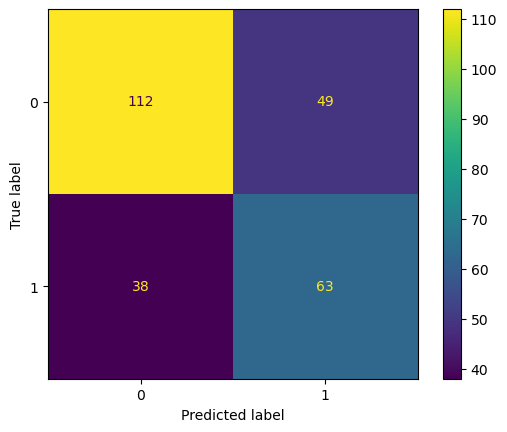

In [234]:
# Display confusion matrix
cm_lr_after = confusion_matrix(y_true=y_val, y_pred=y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_after, display_labels=model_lr_downsampled.classes_)
disp.plot()

plt.show()

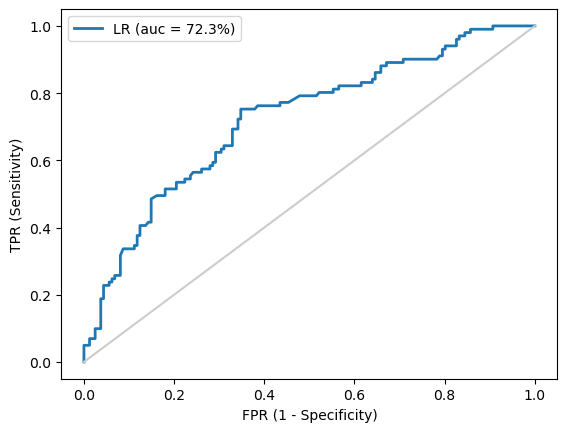

In [235]:
# ROC
fpr_lr, tpr_lr, th_lr = roc_curve(y_val, y_pred_prob_lr[:, -1])

plot_roc_curve([fpr_lr], [tpr_lr], label_list=['LR'], auc_list=[auc_lr_after])

## 5. Feature Importance

In [236]:
# Calculate feature importance
feature_importance = abs(model_lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

feature_importance

array([ 40.49899122,  24.89914995,  22.77177278,  24.21752336,
        57.51131286,  15.09351887,  72.59627909, 100.        ,
        99.99144737,  12.54375668,  27.28558828,  14.73327897])

In [237]:
# Custom function for Feature Importance for LR
import numpy as np

def plot_feature_importance_lr(lr_model, colnames_x, threshold_importance=None):
    # Compute feature importance
    feature_importance = abs(lr_model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())

    # Keep strong importance
    if threshold_importance is not None:
        feature_importance = feature_importance[feature_importance > threshold_importance]

    # Plot importance
    idx_sorted = np.argsort(feature_importance)
    pos = np.arange(idx_sorted.shape[0]) + 0.5

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    ax.barh(pos, feature_importance[idx_sorted], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(np.array(X.columns)[idx_sorted], fontsize=12)
    ax.set_xlabel('Relative Feature Importance')
    
    plt.tight_layout()   
    plt.show()

IndexError: index 9 is out of bounds for axis 0 with size 7

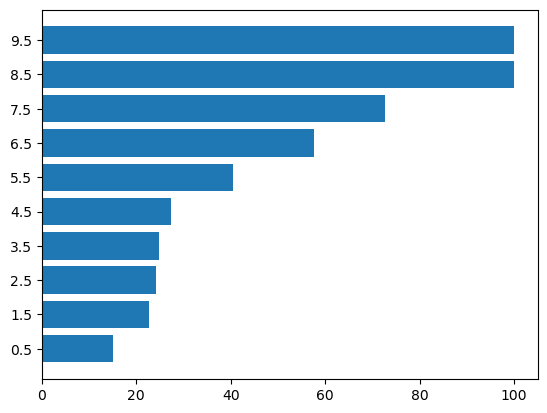

In [238]:
plot_feature_importance_lr(model_lr, colnames_x=X_train_ready.columns, threshold_importance=15)

In [ ]:
# Save model for later use   ##################################################################################################################

# Import library
import joblib

# Save model
joblib.dump(model_lr_downsampled, 'model_lr.pkl')

# 6. Load saved model and do predictions

In [ ]:
# Load saved model

loaded_model = joblib.load('model_lr.pkl')

In [ ]:
loaded_model

In [ ]:
# Do prediction
y_pred = loaded_model.predict(X_val_ready)

In [ ]:
y_pred

In [ ]:
len(y_pred)

In [ ]:
np.unique(y_pred, return_counts=True)